In [1]:
import numpy as np
import sounddevice as sd
import soundfile as sf
from numpy import ndarray
from numpy.fft import fft, ifft, rfft, hfft
from scipy.signal import butter, lfilter, freqz, firwin2, unit_impulse, sosfilt
from shared.record_signal import convert_audio_to_numpy_array
import matplotlib.pyplot as plt

In [2]:
recording_count = 10
fs = 44100

In [3]:
hd600_audios = []

for i in range(10):
    audio, fs = convert_audio_to_numpy_array(f"../HPIRs_Erbes_44100Hz/Measurements/HD600/pass0{i}.wav")
    hd600_audios.append(audio)

In [4]:
n_input = hd600_audios[0].shape[0]
print('Number of Input steps:\t', n_input)

Number of Input steps:	 17640


In [5]:
hd600_fft = []

for audio in hd600_audios:
    y_l = audio[:, 0]
    y_r = audio[:, 1]
    Y_L = fft(y_l)
    Y_R = fft(y_r)
    Y_fft = np.append([Y_L], [Y_R], axis = 0)
    Y_fft = Y_fft.transpose()
    hd600_fft.append(Y_fft)

In [6]:
n_output = hd600_fft[0].shape[0]
print('Number of output points:\t\t', n_output)
n_output_one_sided = int(n_output / 2 + 1)
print("Number of output points (one-sided):\t", n_output_one_sided)

Number of output points:		 17640
Number of output points (one-sided):	 8821


In [7]:
hd600_fft_mean = []
Y_L_fft_sum = np.empty([n_output])
Y_R_fft_sum = np.empty([n_output])

for fft in hd600_fft:
    Y_L_fft_sum = Y_L_fft_sum + fft[:, 0]
    Y_R_fft_sum = Y_R_fft_sum + fft[:, 1]

Y_L_complex_mean = Y_L_fft_sum / recording_count
Y_R_complex_mean = Y_R_fft_sum / recording_count

# crop mirrors
Y_L_complex_mean = Y_L_complex_mean[:n_output_one_sided]
Y_R_complex_mean = Y_R_complex_mean[:n_output_one_sided]

Y_complex_mean = np.append([Y_L_complex_mean], [Y_R_complex_mean], axis = 0)

(20, 22050.0)

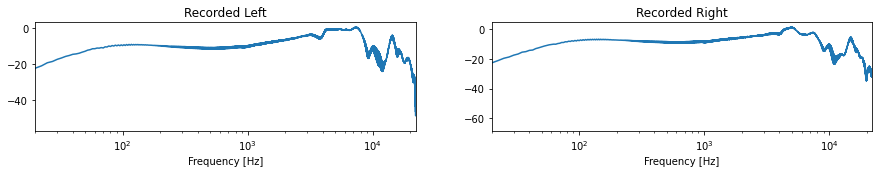

In [8]:
f_vec = np.linspace(0, fs/2, n_output_one_sided)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2), sharex=True)

ax1.set_title('Recorded Left')
ax1.set_xlabel("Frequency [Hz]")

ax2.set_title('Recorded Right')
ax2.set_xlabel("Frequency [Hz]")

# plot outpit without the mirror spectrum
ax1.semilogx(f_vec, 20*np.log10(np.abs(Y_L_complex_mean)))
ax2.semilogx(f_vec, 20*np.log10(np.abs(Y_R_complex_mean)))

ax1.set_xlim([20, fs/2])

Design Bandpass Filter

In [9]:
low_cut = 200
high_cut = 18000
filter_order = 8

In [10]:
def butter_bandpass(low_cut, high_cut, order=8, fs=44100):
    return butter(order, [low_cut, high_cut], fs=fs, btype='band')


In [11]:
def butter_bandpass_filter(data, low_cut, high_cut, order, fs):
    b, a = butter_bandpass(low_cut, high_cut, order, fs)
    filter  = lfilter(b, a, data)

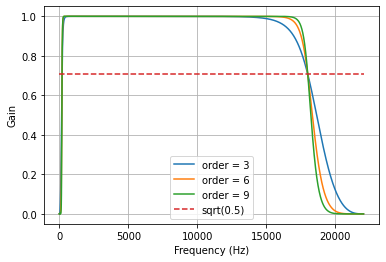

In [12]:
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(low_cut, high_cut, order, fs)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
            '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_45313/2662326787.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(f_vec, 20*np.log10(np.abs(bandlimit_filter)), color='green')


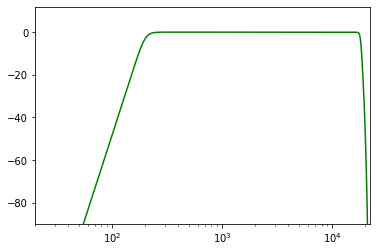

In [13]:
## make fir filter by pushing a dirac through a butterworth SOS (multiple times)

# filter paramters
high_cut = 18000 
low_order = 8
low_cut = 200
high_order = 8

low_pass_filter = high_pass_filter = unit_impulse(n_output)

# lowpass
sos_low_pass = butter(low_order, high_cut, 'lowpass', fs=fs, output='sos')
low_pass_filter = sosfilt(sos_low_pass, low_pass_filter)
low_pass_filter = rfft(low_pass_filter)

# highpass
sos_hp = butter(high_order, low_cut, 'highpass', fs=fs, output='sos')
high_pass_filter = sosfilt(sos_hp, high_pass_filter)
high_pass_filter = rfft(high_pass_filter)

bandlimit_filter = high_pass_filter * low_pass_filter

#plot
plt.semilogx(f_vec, 20*np.log10(np.abs(bandlimit_filter)), color='green')
plt.xlim([20, fs/2])
plt.ylim([-90, 12]);


Apply Bandpass Filter to L|R channels

In [17]:
# Y_L_bandpassed = butter_bandpass_filter(Y_complex_mean[0], low_cut, high_cut, 8, fs)
# Y_R_bandpassed = butter_bandpass_filter(Y_complex_mean[1], low_cut, high_cut, 8, fs)

# Y_bandpassed = np.append([Y_L_bandpassed], [Y_R_bandpassed], axis = 0)

In [18]:
Y_L_bandpassed = bandlimit_filter * Y_complex_mean[0]
Y_R_bandpassed = bandlimit_filter * Y_complex_mean[1]

Y_bandpassed = np.append([Y_L_bandpassed], [Y_R_bandpassed], axis = 0)

Visualize Bandpassed Recording

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_45313/2616113072.py:11: RuntimeWarning: divide by zero encountered in log10
  ax1.semilogx(f_vec, 20*np.log10(np.abs(Y_L_bandpassed)))
/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_45313/2616113072.py:12: RuntimeWarning: divide by zero encountered in log10
  ax2.semilogx(f_vec, 20*np.log10(np.abs(Y_R_bandpassed)))


(20, 22050.0)

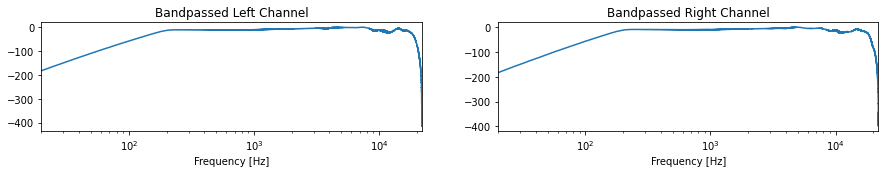

In [20]:
f_vec = np.linspace(0, fs/2, n_output_one_sided)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2), sharex=True)

ax1.set_title('Bandpassed Left Channel')
ax1.set_xlabel("Frequency [Hz]")

ax2.set_title('Bandpassed Right Channel')
ax2.set_xlabel("Frequency [Hz]")

# plot outpit without the mirror spectrum
ax1.semilogx(f_vec, 20*np.log10(np.abs(Y_L_bandpassed)))
ax2.semilogx(f_vec, 20*np.log10(np.abs(Y_R_bandpassed)))

ax1.set_xlim([20, fs/2])

Design Regularisation Filter

In [ ]:
taps = 50
freqs = [0, 0.2, 0.6, 1]
gain = np.array([-20, -20, 0, 0]).astype(float)
linear_gain = 10**(gain/20)
linear_gain[-1] = 0

In [ ]:
linear_gain

In [ ]:
b = firwin2(taps, freqs, linear_gain)
B = fft(b)

In [ ]:
Y_L_regularised = lfilter(b, 1,)

In [ ]:
Y_bandpassed